In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from cycler import cycler

import ot

import numpy as np
from jax import numpy as jnp
from jax import random

import qutip as qt
from qutip import Bloch

from opt_einsum import contract

from src.QDDPM_jax import QDDPM, HaarSampleGeneration
from src.distance_jax import sinkhornDistance

c:\ProgramData\anaconda3\Lib\site-packages\qutip\__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(
C:\Users\franc\AppData\Roaming\Python\Python311\site-packages\jax\_src\api_util.py:174: SyntaxWarning: Jitted function has static_argnums=(2, 3, 4), but only accepts 4 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "


In [2]:
def bloch_xyz(inputs):
    # obtain bloch sphere representation vector
    rho = contract('mi,mj->mij', inputs, inputs.conj())
    sigmas = [qt.sigmax().full(), qt.sigmay().full(), qt.sigmaz().full()]
    pos = [np.real(contract('mii->m', contract('mij,jk->mik', rho, x))) for x in sigmas]
    
    return pos

In [3]:
n, na = 1, 1
T = 20
L = 4

Ndata = 100
epochs = 1201

states_diff = jnp.load('data/cluster/cluster0Diff_n1T20_N100.npy')
params_tot = jnp.load('output/cluster0Diff_n1T20_N100_param_sink.npy')
state_target = states_diff[0]

model = QDDPM(n=n, na=na, T=T, L=L)
inputs_T_train = HaarSampleGeneration(Ndata, 2 ** n, seed=42)
dataset_train = model.backDataGeneration(inputs_T_train, params_tot, Ndata)

In [4]:
n_test = 10000
test_dist = []
for k in range(50, 50 + n_test):
    inputs_T_test = HaarSampleGeneration(Ndata, 2 ** n, seed=k)
    dataset_test = model.backDataGeneration(inputs_T_test, params_tot, Ndata)
    wdist = []
    for t in range(T + 1, 0, -1):
        M = 1. - jnp.abs(contract('mi,ni->mn', dataset_test[t].conj(), state_target)) ** 2.
        wdist.append(ot.solve(M).value) # W Dist

    test_dist.append(wdist)

test_dist = jnp.flip(jnp.array(test_dist))
test_dist_mean = test_dist.mean(axis=0)
test_dist_sd = test_dist.std(axis=0)

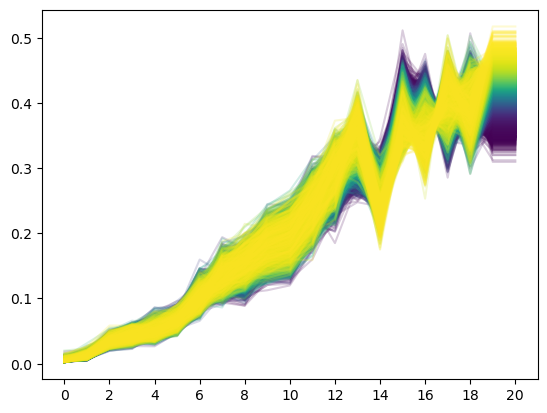

In [5]:
test_dist_plt = test_dist[test_dist[:, T + 1].argsort()].T

fig, ax = plt.subplots()
ax.set_prop_cycle(color=plt.cm.viridis(np.linspace(0, 1, n_test)))
ax.plot(test_dist_plt, alpha=0.2);
ax.set_xticks(range(0, 21, 2));

In [6]:
dist_list = []
for i in range(T + 1):
    M_diff = 1. - jnp.abs(contract('mi,ni->mn', states_diff[i].conj(), state_target)) ** 2.
    diff_dist = ot.solve(M_diff).value

    M_train = 1. - jnp.abs(contract('mi,ni->mn', dataset_train[i].conj(), state_target)) ** 2.
    train_dist = ot.solve(M_train).value
    
    dist_list.append([diff_dist, train_dist])

dist_list = jnp.array(dist_list)

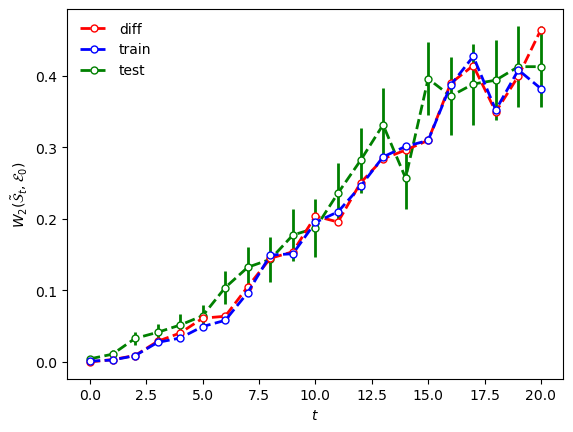

In [7]:
fig, ax = plt.subplots()
ax.set_prop_cycle(cycler(color=['r', 'b', 'g']))
ax.plot(np.array(dist_list), 'o--', markersize=5, mfc='white', lw=2, label=['diff', 'train'], zorder=5)
ax.errorbar(x=range(21), y=test_dist_mean, yerr=2 * test_dist_sd, label='test', marker='o', markersize=5, mfc='w', lw=2, linestyle='--')
ax.set_ylabel('$W_2(\\tilde{\mathcal{S}}_t,\mathcal{E}_0)$')
ax.set_xlabel('$t$')
handles, labels = ax.get_legend_handles_labels()
handles[2] = handles[2][0]
ax.legend(handles, labels, loc=2, framealpha=0);

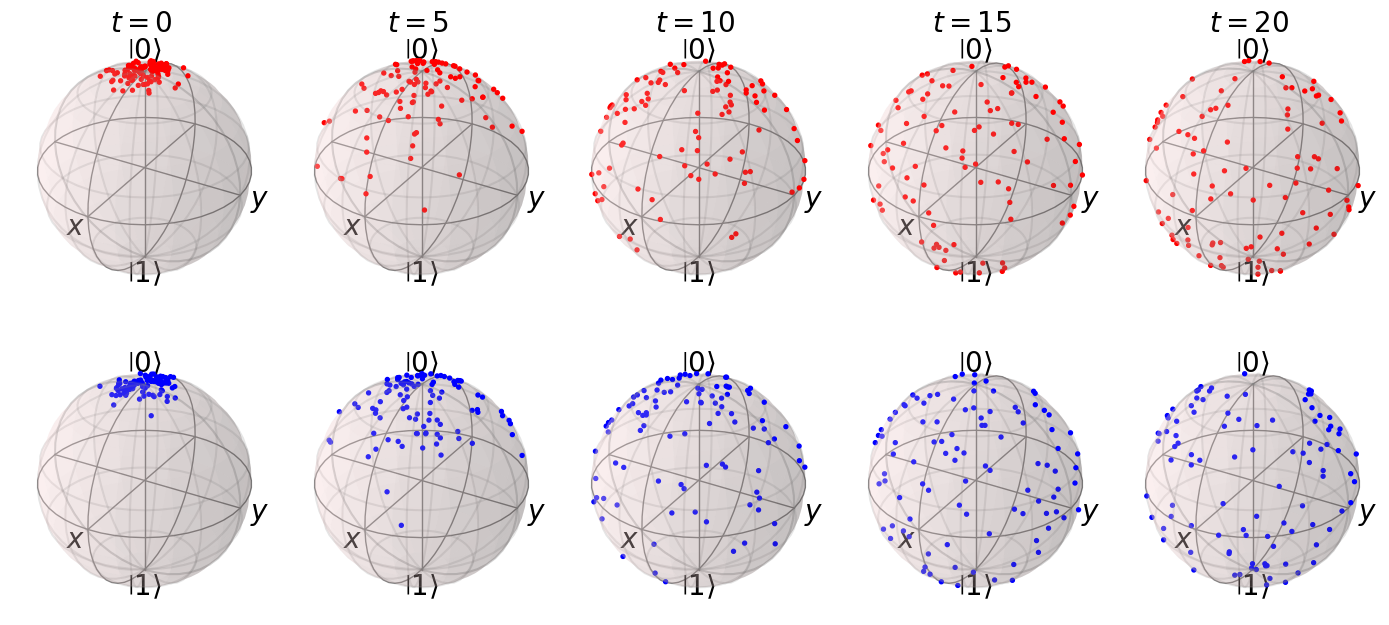

In [8]:
# bloch visualize on the backward denoise process
fig, axs = plt.subplots(2, 5, figsize=(14,7), subplot_kw={'projection': '3d'})
cc = 0
for i in range(0, T+1, 5):
    xs0, ys0, zs0 = bloch_xyz(states_diff[i])
    xs1, ys1, zs1 = bloch_xyz(dataset_train[i])
    b0 = Bloch(fig=fig, axes=axs[0,cc])
    b0.clear()
    b0.add_points([xs0, ys0, zs0])
    b0.point_color = ['r']*Ndata
    b0.point_style = 'm'
    b0.point_size = 8 * np.ones(Ndata)
    b0.render()
    b1 = Bloch(fig=fig, axes=axs[1,cc])
    b1.clear()
    b1.add_points([xs1, ys1, zs1])
    b1.point_color = ['b']*Ndata
    b1.point_style = 'm'
    b1.point_size = 8 * np.ones(Ndata)
    b1.render()
    axs[0,cc].set_title(r'$t=%d$'%i, fontsize=20)
    cc += 1
plt.tight_layout()
plt.show()
plt.close()

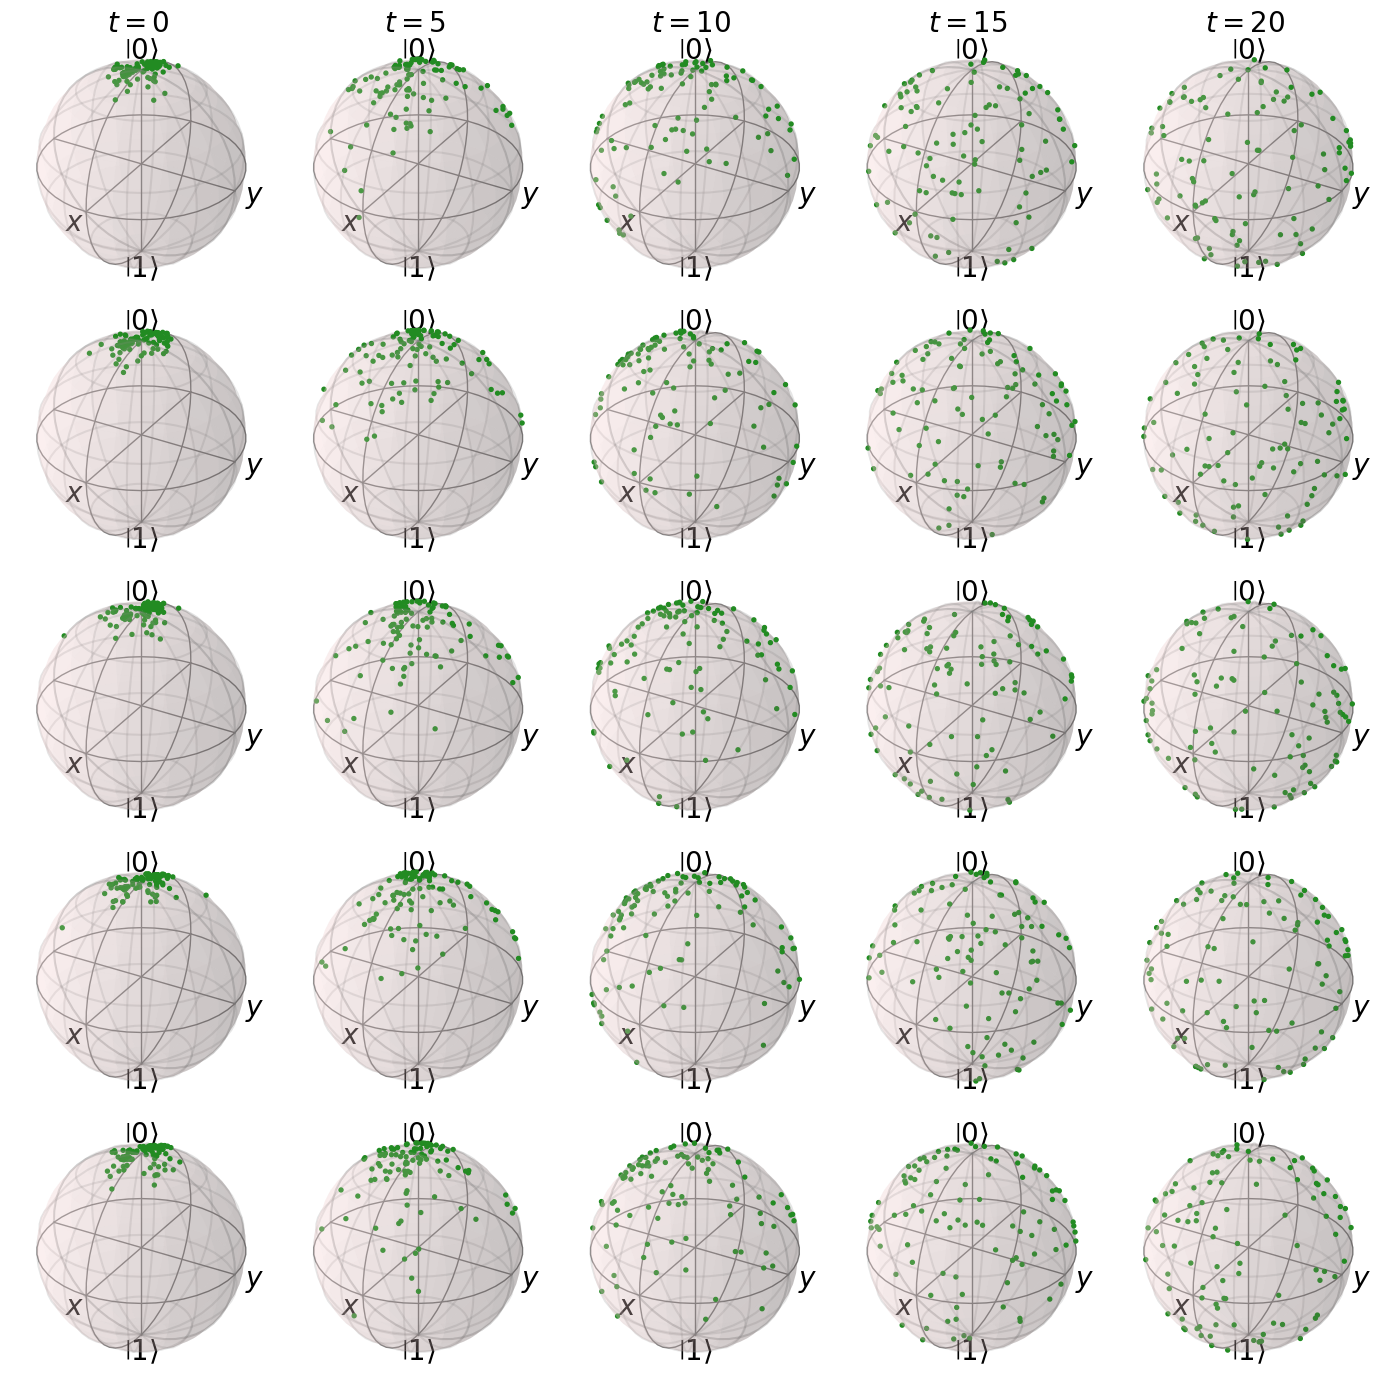

In [9]:
seed = [64, 72, 100, 120, 356]
fig, axs = plt.subplots(5,5, figsize=(14,14), subplot_kw={'projection': '3d'})
cc = 0
for i in range(0, T+1, 5):
    for k, s in enumerate(seed):
        inputs_T_test = HaarSampleGeneration(Ndata, 2 ** n, seed=s)
        dataset_test = model.backDataGeneration(inputs_T_test, params_tot, Ndata)
        xs0, ys0, zs0 = bloch_xyz(dataset_test[i])
        b0 = Bloch(fig=fig, axes=axs[k,cc])
        b0.clear()
        b0.add_points([xs0, ys0, zs0])
        b0.point_color = ['forestgreen']*Ndata
        b0.point_style = 'm'
        b0.point_size = 8 * np.ones(Ndata)
        b0.render()

    axs[0,cc].set_title(r'$t=%d$'%i, fontsize=20)
    cc += 1
plt.tight_layout()
plt.show()
plt.close()

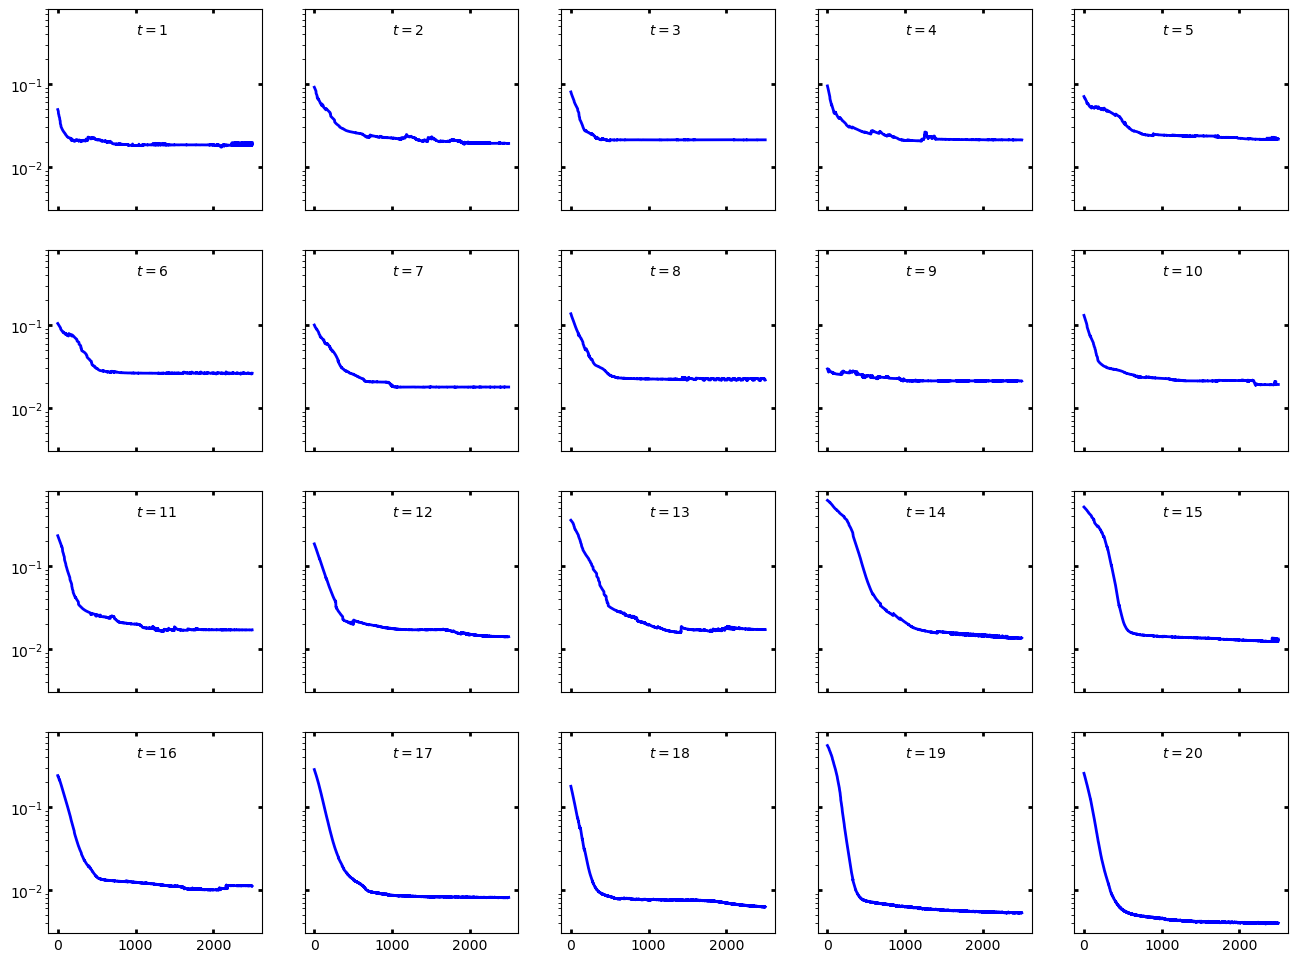

In [10]:
# plot loss
loss_array = jnp.load('output/cluster0Diff_n1T20_N100_loss.npy')
fig, axs = plt.subplots(4, 5, figsize=(16, 12), sharex=True, sharey=True)
for i in range(T):
    axs[i // 5, i % 5].plot(loss_array[i], 'b', lw=2)
    axs[i // 5, i % 5].tick_params(direction='in', length=3, width=2, top='on', right='on', labelsize=10)
    axs[i // 5, i % 5].text(x=1000, y=0.4, s=r'$t=%d$'%(i+1), fontsize=10)
    axs[i // 5, i % 5].set_yscale('log')